In [2]:
import numpy as np
import pandas as pd

import Bio
from Bio import SeqIO
from Bio import Entrez
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import os

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#for seq_record in SeqIO.parse("sequences/genome/AY029768.1_MYS.fasta", "fasta"):
for seq_record in SeqIO.parse("sequences/genome/NC_00278.1_MYS.fasta", "fasta"):
    
    # just wanted to do a sanity check
    print(f"Malaysian strain genome size: {len(seq_record)}")

Malaysian strain genome size: 18246


In [3]:
for seq_record in SeqIO.parse("sequences/genome/AY988601.1_BGD.fasta", "fasta"):
    
    # just wanted to do a sanity check
    print(f"Bangaldeshi strain genome size: {len(seq_record)}")

Bangaldeshi strain genome size: 18252


# 1. BLAST the glycoprotein and phosphoprotein sequences to get all sequences from NCBI

Used reference sequences `sequences/PG/ref_G_seq` and `sequences/PG/ref_P_seq` for the glycoprotein and phosphoproteins. Queried these on BLAST using <i>Henipaviruses</i> as the search organism. 

83 full search results for G (could be individual protein, multiple, or full genome) stored at `sequences/PG/glyco_blast_83.fasta`, and 80 full search results for P stored at `sequences/PG/phospho_blast_80.fasta`. Removed duplicates in Geneious.

Descriptions stored at `sequences/glyco_blast_descriptions.csv` and `sequences/phospho_blast_descriptions.csv`.

```bash
bowtie2-build sequences/genome/AY029768.1_MYS_CDS.fna MYS_cds
bowtie2 -x MYS_cds -f sequences/PG/G_seqs.fasta -S G_aln.sam
```

The sequence headers were updated, and the V, W, and C proteins were removed because they are duplicates of the phosphoprotein sequence. <b>This was found to cause problems when aligning the glycoprotein sequences</b>. It makes sense that you shouldn't have redundant sequences in a reference sequence, but I'm not sure why it didn't cause problems for the phosphoprotein alignment. 

In [203]:
def get_ncbi_accessions(id_list):
    
    #Entrez.email='skulkarni@g.harvard.edu'

    # search Genbank, returns accession numbers
    handle=Entrez.esearch(db='nucleotide', retmax=1000, term=",".join(id_list), idtype="acc") 
    record = Entrez.read(handle)
    
    handle.close()
    fetch = Entrez.efetch(db='nucleotide', id=",".join(record['IdList']), rettype='gb', retmode='text')
    gb=fetch.read()
    
    # the first one is an empty string because it's what comes before the first locus
    found_seq = list(gb.split("LOCUS"))[1:]
    print(f"Found {len(found_seq)} out of {len(id_list)} NCBI accessions!")
    
    # remove the sequences becuase they make the strings unnecessarily long
    found_seq = [isolate.split("FEATURES")[0] for isolate in found_seq]
    
    return found_seq

In [238]:
glyco_found = get_ncbi_accessions(G_tree_names)

Found 84 out of 84 NCBI accessions!


In [239]:
phospho_found = get_ncbi_accessions(P_tree_names)

Found 81 out of 81 NCBI accessions!


In [244]:
no_date_indices = [i for i in range(len(glyco_found)) if "VRL" not in glyco_found[i]]
print(no_date_indices)

no_date_indices = [i for i in range(len(phospho_found)) if "VRL" not in phospho_found[i]]
print(no_date_indices)

[]
[]


# 2. Single nucleotide polymorphism (SNP) calling

## End goal is to convert the FASTA file into a VCF (variant calling format) file

<b>Amazing tutorial:</b> https://www.ebi.ac.uk/sites/ebi.ac.uk/files/content.ebi.ac.uk/materials/2014/140217_AgriOmics/dan_bolser_snp_calling.pdf

## Exact code to run for both P and G aligning to both reference genomes:

```bash
bash align_make_vcf.sh "sequences/genome/AY988601.1_BGD_CDS.fna" "sequences/PG/P_seqs.fasta" "alignments" "P_BGD"
bash align_make_vcf.sh "sequences/genome/NC_00278.1_MYS_CDS.fna" "sequences/PG/P_seqs.fasta" "alignments" "P_MYS"

bash align_make_vcf.sh "sequences/genome/AY988601.1_BGD_CDS.fna" "sequences/PG/G_seqs.fasta" "alignments" "G_BGD"
bash align_make_vcf.sh "sequences/genome/NC_00278.1_MYS_CDS.fna" "sequences/PG/G_seqs.fasta" "alignments" "G_MYS"
```

The above bash script runs the following steps, adapted from the linked tutorial above:

<b></b>
```bash
bwa index sequences/genome/AY029768.1_MYS_CDS.fna
```

<b>Perform the alignment</b>
```bash
bwa aln sequences/genome/AY029768.1_MYS_CDS.fna sequences/PG/P_seqs.fasta > alignments/P_MYS_aln.sai
```

<b>Convert to SAM file format, which is human-readable</b>
```bash
bwa samse sequences/genome/AY029768.1_MYS_CDS.fna alignments/P_MYS_aln.sai sequences/PG/P_seqs.fasta > alignments/P_MYS_aln.sam
```

<b>Convert SAM to BAM and sort the BAM file</b>
```bash
   samtools view -b alignments/G_BGD_aln.sam > alignments/G_BGD_aln.bam
   samtools sort alignments/G_BGD_aln.bam -o alignments/G_BGD_aln_sorted.bam
```

<b>Index the genome file again with `samtools`</b>
```bash
samtools faidx sequences/genome/AY029768.1_MYS_CDS.fna
```

<b>Run 'mpileup' to generate VCF format</b>
```bash
bcftools mpileup -f sequences/genome/AY988601.1_BGD_CDS.fna alignments/P_MYS_aln_sorted.bam > alignments/P_MYS_aln.bcf
```

<b>Call SNPs</b>
```bash
bcftools view -v snps alignments/P_MYS_aln.bcf > alignments/P_MYS_SNPs.vcf
```

# 3. Make trees using the G and P CDS's

```bash
fasttree -nt sequences/PG/G_seqs.fasta > trees/G_cds.nwk
fasttree -nt sequences/PG/P_seqs.fasta > trees/P_cds.nwk
```

Another reference: https://hbctraining.github.io/In-depth-NGS-Data-Analysis-Course/sessionVI/lessons/01_alignment.html

# 4. Deduplicate and remake trees

## Then remove sequences where more than 1% of the nucleotides are N

In [17]:
# G_seqs = [(seq_record.id, str(seq_record.seq)) for seq_record in SeqIO.parse("sequences/PG/G_seqs.fasta", "fasta")]
# P_seqs = [(seq_record.id, str(seq_record.seq)) for seq_record in SeqIO.parse("sequences/PG/P_seqs.fasta", "fasta")]

def count_ambig_nuc(seq):
    
    count = 0
    for char in seq:
        if char == "N":
            count += 1
    return count

# ambig_G = [count_ambig_nuc(seq[1]) for seq in G_seqs]
# ambig_P = [count_ambig_nuc(seq[1]) for seq in P_seqs]

# print(np.unique(ambig_G) / len(G_seqs[0][1]))
# print(np.unique(ambig_P) / len(P_seqs[0][1]))

[0.         0.00221117 0.00718629 0.00773908 0.01050304 0.01547816
 0.04256495 0.08181316 0.11111111 0.11719182 0.18794914 0.22443339
 0.32172471 0.47263682]
[0.         0.00046948 0.0056338  0.00892019 0.01126761 0.08309859]


## More sanity checks

In [24]:
def deduplicate_seq(og_fasta):
    
    seqs = [(seq_record.id, str(seq_record.seq)) for seq_record in SeqIO.parse(og_fasta, "fasta")]
    
    seqs_df = pd.DataFrame(seqs).rename(columns={0:"ID", 1:"Seq"})

    # check that they are sorted alphabetically by ID
    assert sum(seqs_df.ID.values != np.sort(seqs_df.ID.values)) == 0

    # keeps only the first occurrence. So there are 46 unique glycoprotein sequences and 50 unique phosphoprotein sequences
    return seqs_df.drop_duplicates(subset="Seq", keep="first")

In [25]:
# using the 1% N thresholding leaves ~40 and 47 sequences, respectively

keep_G = deduplicate_seq("sequences/PG/G_seqs.fasta")
with open("seq_for_analysis/G_dedup.fasta", "w+") as file:
    
    for _, row in keep_G.iterrows():
        file.write(">" + row["ID"] + "\n")
        file.write(row["Seq"] + "\n")
        
keep_P = deduplicate_seq("sequences/PG/P_seqs.fasta")
with open("seq_for_analysis/P_dedup.fasta", "w+") as file:
    
    for _, row in keep_P.iterrows():
        file.write(">" + row["ID"] + "\n")
        file.write(row["Seq"] + "\n")

keep_G.shape, keep_P.shape

((50, 2), (51, 2))

# Bar chart of the numbers of sequences after filtering steps

In [55]:
G_lengths = {}
P_lengths = {}

with open("sequences/PG/G_seqs.fasta", "r") as file:
    lines = file.readlines()
    G_lengths["All"] = len(lines) / 2
    
with open("seq_for_analysis/G_dedup.fasta", "r") as file:
    lines = file.readlines()
    G_lengths["Unique"] = len(lines) / 2
    
with open("seq_for_analysis/G_no_stop_codons.fasta", "r") as file:
    lines = file.readlines()
    G_lengths["For Analysis"] = len(lines) / 2

with open("sequences/PG/P_seqs.fasta", "r") as file:
    lines = file.readlines()
    P_lengths["All"] = len(lines) / 2
    
with open("seq_for_analysis/P_dedup.fasta", "r") as file:
    lines = file.readlines()
    P_lengths["Unique"] = len(lines) / 2
    
with open("seq_for_analysis/P_no_stop_codons.fasta", "r") as file:
    lines = file.readlines()
    P_lengths["For Analysis"] = len(lines) / 2

In [56]:
df_lengths = pd.concat([pd.DataFrame(G_lengths, index=[0]), 
                        pd.DataFrame(P_lengths, index=[0])]).T.reset_index()

df_lengths.columns = ["Type", "G", "P"]
df_lengths[["G", "P"]] = df_lengths[["G", "P"]].astype(int)

df_lengths = df_lengths.melt(id_vars="Type")
df_lengths.columns = ["Type", "Protein", "# Sequences"]

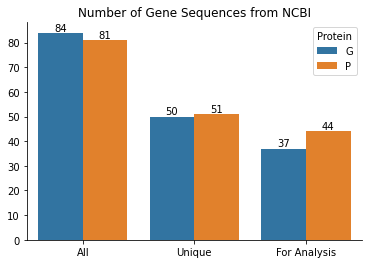

In [68]:
ax = sns.barplot(data=df_lengths, 
                 x="Type", y="# Sequences",
                 hue="Protein", 
                )

# add value labels
for container in ax.containers:
    ax.bar_label(container)

sns.despine()
plt.xlabel("")
plt.ylabel("")
plt.title("Number of Gene Sequences from NCBI")
plt.savefig("num_seq_summary.png", dpi=150)